In [1]:
import pandas as pd
import numpy as np
import pickle 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

# For text cleaning - language detection
from langdetect import detect
from langdetect import DetectorFactory

# For text cleaning - basic cleaning
from bs4 import BeautifulSoup # For removing html components
import string # For removing punctuation
import re 

# For text preprocessing - stemming & lemmatizing
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# For dataset split
from sklearn.model_selection import train_test_split

# For text vectorization and label
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('IMDB Dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
DetectorFactory.seed = 42 # set seed for reproduction

def language_detection(x:str):
    text = x.split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        except Exception as e:
            lang = "unknown"
            pass
    return lang

data['language'] = data['review'].progress_apply(language_detection)
data['language'].value_counts()

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:23<00:00, 347.50it/s]


language
en    49999
id        1
Name: count, dtype: int64

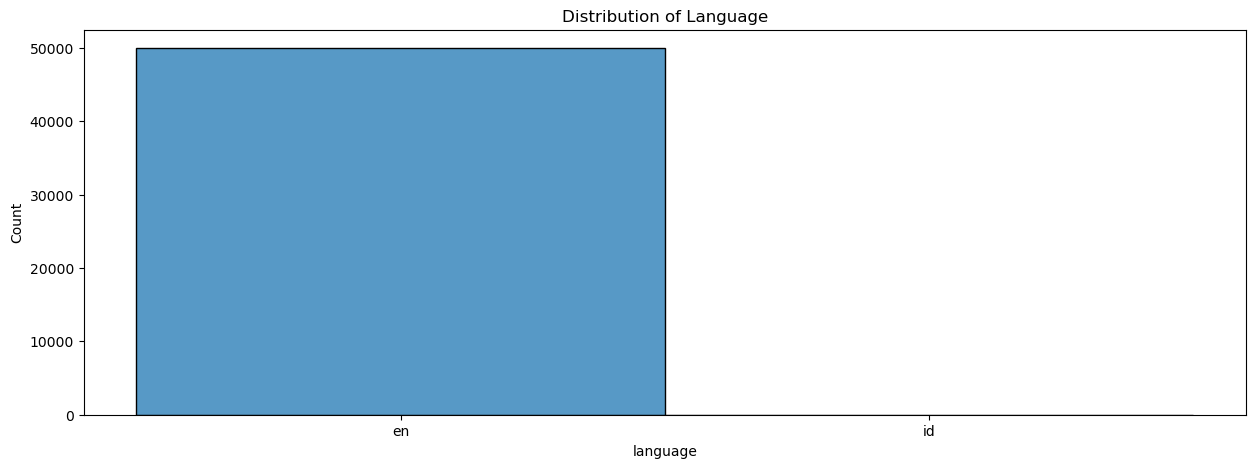

In [6]:
fig = plt.figure(figsize=(15, 5))
sns.histplot(data=data['language'])
plt.title("Distribution of Language")
plt.show()

In [7]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def clean_text(text):
    # Uniode text
    if isinstance(text, float):
        text = str(text)
    if isinstance(text, int):
        text = str(text)
    if not isinstance(text, str):
        text = text.decode('utf-8', 'ignore')
    
    text = text.lower() # Lowercase text
    
    text = re.sub(r'\W', ' ', text) # Remove all the special characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # Remove all single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) # Remove single characters from the start
    text = re.sub(r'\s+', ' ', text, flags=re.I) # Substituting multiple spaces with single space
    text = re.sub(r'#', '', text)# Remove hashtag sign
    
    # Remove possible links
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    
    # Remove emojis
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols                                                                         
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    text = regrex_pattern.sub(r'',text)
    
    return text

def decontracted(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"can\'t", "cannot", text)
    text = re.sub(r"it\'s", "it is", text)
    text = re.sub(r"there\'s", "there is", text)
    text = re.sub(r"nothing\'s", "nothing is", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\“", "", text)
    text = re.sub(r"\”", "", text)
    text = re.sub(r"\…", "", text)
    return text

def remove_punc(text):
    text =  text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([word for word in text.split()])
    return text

additional_stopwords = ["``","''","br",'--', 'u', 'b', 'c', 'd', 'x', 'xf', 'f', 'p', 'xb', 'e']
STOPWORDS = set(stopwords.words('english')+additional_stopwords)
def remove_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # Remove stopwords from text
    return text

In [8]:
data['cleaned_review'] = data['review'].progress_apply(strip_html).apply(clean_text).apply(decontracted).apply(remove_punc).apply(remove_stopwords)
data.head()

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:06<00:00, 7883.04it/s]


,review,sentiment,language,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,en,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,positive,en,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,en,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,en,basically family little boy jake thinks zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,en,petter mattei love time money visually stunnin...


In [9]:
def stem_text(x):
    stemmer = PorterStemmer()
    x = word_tokenize(x)
    stem = ''
    
    for i in x:
        stem += stemmer.stem(i) + ' '
        
    return stem

In [10]:
data['cleaned_stemmed_review'] = data['cleaned_review'].progress_apply(stem_text)
data.head()

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:22<00:00, 350.50it/s]


,review,sentiment,language,cleaned_review,cleaned_stemmed_review
0,One of the other reviewers has mentioned that ...,positive,en,one reviewers mentioned watching 1 oz episode ...,one review mention watch 1 oz episod hook righ...
1,A wonderful little production. <br /><br />The...,positive,en,wonderful little production filming technique ...,wonder littl product film techniqu unassum old...
2,I thought this was a wonderful way to spend ti...,positive,en,thought wonderful way spend time hot summer we...,thought wonder way spend time hot summer weeke...
3,Basically there's a family where a little boy ...,negative,en,basically family little boy jake thinks zombie...,basic famili littl boy jake think zombi closet...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,en,petter mattei love time money visually stunnin...,petter mattei love time money visual stun film...


In [11]:
print(f"original: {data['review'].apply(lambda x: len(x.split())).sum()}")

print(f"after basic cleaning: {data['cleaned_review'].apply(lambda x: len(x.split())).sum()}")

print(f"after stemming: {data['cleaned_stemmed_review'].apply(lambda x: len(x.split())).sum()}")

original: 11557847
after basic cleaning: 5965854
after stemming: 5969055


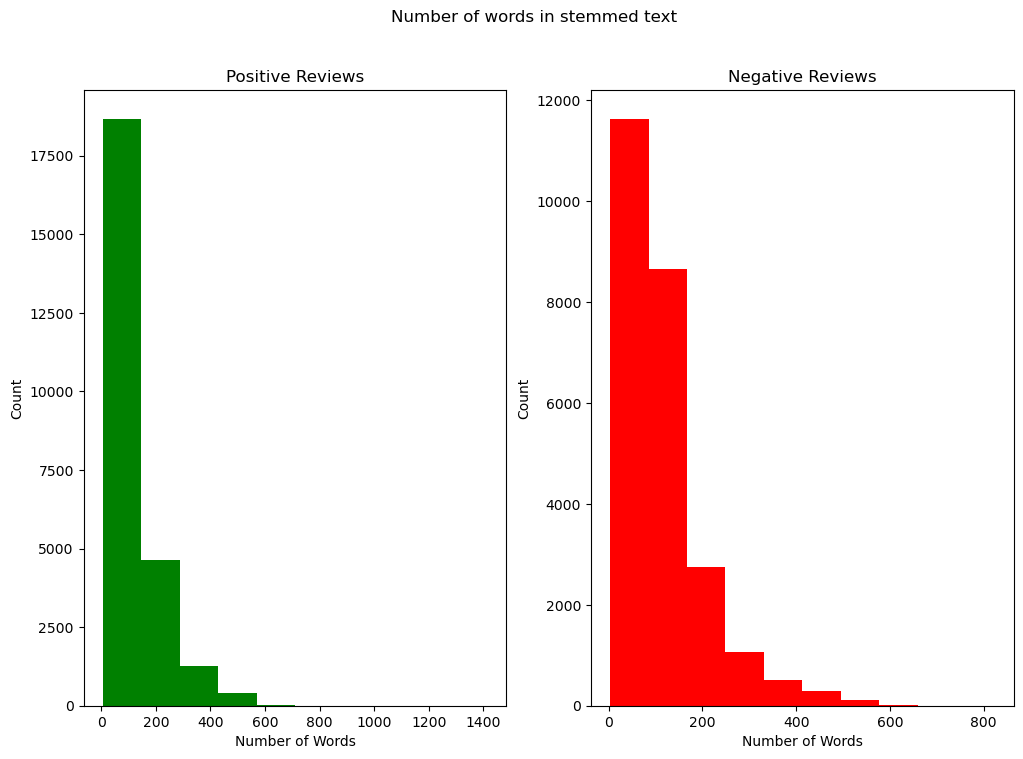

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=data[data['sentiment'] == 'positive']['cleaned_stemmed_review'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Count')
text_len=data[data['sentiment'] == 'negative']['cleaned_stemmed_review'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Count')
fig.suptitle('Number of words in stemmed text')
plt.show()

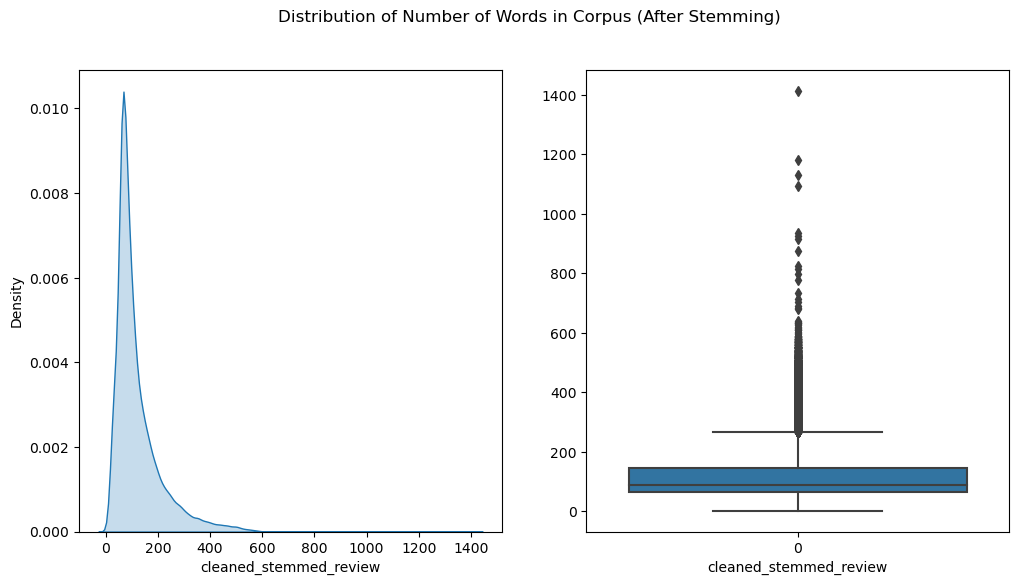

In [13]:
num_words_train = data['cleaned_stemmed_review'].apply(lambda x: len(x.split()))
fig, axes = plt.subplots(1, 2, figsize=(12,6))
sns.kdeplot(data['cleaned_stemmed_review'].apply(lambda x: len(x.split())), fill=True, ax=axes[0])
sns.boxplot(data['cleaned_stemmed_review'].apply(lambda x: len(x.split())), ax=axes[1])
axes[1].set_xlabel("cleaned_stemmed_review")
fig.suptitle('Distribution of Number of Words in Corpus (After Stemming)')
plt.show()


In [14]:
word_list = data['cleaned_review'].str.split()
top = Counter([item for sublist in word_list for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp.columns = ['common_words','count']
temp.style.background_gradient(cmap='Blues')

,common_words,count
0,movie,87937
1,film,79674
2,one,53585
3,like,40160
4,good,29737
5,time,25100
6,even,24855
7,would,24599
8,story,23110
9,really,23089


In [15]:
features = ['cleaned_review', 'cleaned_stemmed_review']
target='sentiment'

data[target] = pd.get_dummies(data[target]).values
print('Shape of label tensor:', data[target].shape)

data[target].value_counts()

Shape of label tensor: (50000,)


sentiment
False    25000
True     25000
Name: count, dtype: int64

In [16]:
# Splitting the dataset into 60/20/20
def split_data(X, Y, test_size=0.2, val_size = 0.2, seed=42):
    X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, Y,
                                                        test_size = test_size, 
                                                        random_state = seed, stratify=Y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, 
                                                        y_train_valid,
                                                        test_size = val_size/(1-test_size), 
                                                        random_state = seed, stratify=y_train_valid)
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(data[features], data[target])
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_valid: {X_val.shape}")
print(f"Shape of y_valid: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (30000, 2)
Shape of y_train: (30000,)
Shape of X_valid: (10000, 2)
Shape of y_valid: (10000,)
Shape of X_test: (10000, 2)
Shape of y_test: (10000,)


In [35]:
X_train_dict = {}
X_val_dict = {}
X_test_dict = {}

methods = ['index', 'bow', 'tfidf']

MAX_SEQUENCE_LENGTH = 500 
MAX_NB_WORDS = 50000
EMBEDDING_DIM = 100

In [48]:
def keras_token_transform(tokenizer, X):
    X = tokenizer.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
    return X

def index_vectorization(X_train, X_val, X_test):
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(X_train)
    word_index = tokenizer.word_index
    
    X_train_vec = keras_token_transform(tokenizer, X_train)
    X_val_vec = keras_token_transform(tokenizer, X_val)
    X_test_vec = keras_token_transform(tokenizer, X_test)
    return X_train_vec, X_val_vec, X_test_vec

method = methods[0]
for feature in features:
    X_train_dict[f'{method}_{feature}'], X_val_dict[f'{method}_{feature}'], X_test_dict[f'{method}_{feature}'] = index_vectorization(X_train[feature].values, X_val[feature].values, X_test[feature].values) 
    print(f"First example of {feature} after {method} vectorization")
    print(X_train_dict[f'{method}_{feature}'][0])

First example of cleaned_review after index vectorization
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0

In [37]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="tensorflow")

In [49]:
def bow_vectorizaion(X_train, X_val, X_test):
    clf = CountVectorizer(ngram_range=(1,2), max_features=MAX_SEQUENCE_LENGTH).fit(X_train)
    X_train_vec =  clf.transform(X_train).toarray()
    X_val_vec = clf.transform(X_val).toarray()
    X_test_vec = clf.transform(X_test).toarray()
    
    return X_train_vec, X_val_vec, X_test_vec

method = methods[1]
for feature in features:
    X_train_dict[f'{method}_{feature}'], X_val_dict[f'{method}_{feature}'], X_test_dict[f'{method}_{feature}'] = bow_vectorizaion(X_train[feature], X_val[feature], X_test[feature])
    print(f"First example of {feature} after {method} vectorization")
    print(X_train_dict[f'{method}_{feature}'][0])

First example of cleaned_review after bow vectorization
[2 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 0 3 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 2
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 3 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 2 0 2 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 5 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 3 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0

In [50]:
def tfidf_vectorizaion(X_train, X_val, X_test):
    clf = CountVectorizer(ngram_range=(1,2), max_features=MAX_SEQUENCE_LENGTH).fit(X_train)
    X_train_cnt_vec =  clf.transform(X_train)
    X_valid_cnt_vec = clf.transform(X_val)
    X_test_cnt_vec = clf.transform(X_test)
    
    tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cnt_vec)
    X_train_vec = tf_transformer.transform(X_train_cnt_vec).toarray()
    X_val_vec = tf_transformer.transform(X_valid_cnt_vec).toarray()
    X_test_vec = tf_transformer.transform(X_test_cnt_vec).toarray()
    
    return X_train_vec, X_val_vec, X_test_vec

method = methods[2]
for feature in features:
    X_train_dict[f'{method}_{feature}'], X_val_dict[f'{method}_{feature}'], X_test_dict[f'{method}_{feature}'] = tfidf_vectorizaion(X_train[feature], X_val[feature], X_test[feature])
    print(f"First example of {feature} after {method} vectorization")
    print(X_train_dict[f'{method}_{feature}'][0])

First example of cleaned_review after tfidf vectorization
[0.16081486 0.         0.10306083 0.         0.         0.
 0.         0.         0.         0.         0.07958258 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.09216993
 0.         0.         0.         0.         0.         0.
 0.10391275 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.11566307 0.
 0.         0.         0.         0.         0.         0.
 0.06903236 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.06537344 0.         0.         0.11563819
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.     

In [51]:
for method in methods:
    for feature in features:
        print(f"Shape of {feature} X_train after {method} vectorization", X_train_dict[f'{method}_{feature}'].shape)

Shape of cleaned_review X_train after index vectorization (30000, 500)
Shape of cleaned_stemmed_review X_train after index vectorization (30000, 500)
Shape of cleaned_review X_train after bow vectorization (30000, 500)
Shape of cleaned_stemmed_review X_train after bow vectorization (30000, 500)
Shape of cleaned_review X_train after tfidf vectorization (30000, 500)
Shape of cleaned_stemmed_review X_train after tfidf vectorization (30000, 500)


In [52]:
def save_data(data_dict, file_name):
    with open(file_name, 'wb') as file:
        pickle.dump(data_dict, file)

def load_data(file_name):
    loaded_data = {}
    with open(file_name, 'rb') as file:
        loaded_data = pickle.load(file)
    return loaded_data

In [53]:
save_data(X_train_dict, "x_train_dict.pkl")
save_data(X_test_dict, "x_test_dict.pkl")
save_data(X_val_dict, "x_val_dict.pkl")

In [54]:
X_train_dict = load_data("x_train_dict.pkl")
X_test_dict = load_data("x_test_dict.pkl")
X_val_dict = load_data("x_val_dict.pkl")

In [55]:
def create_lstm_model():
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

lstm_model_index = create_lstm_model()
lstm_model_index.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 100)          5000000   
                                                                 
 spatial_dropout1d_2 (Spati  (None, 500, 100)          0         
 alDropout1D)                                                    
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5080501 (19.38 MB)
Trainable params: 5080501 (19.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
EPOCHS = 10
BATCH_SIZE = 32
history = lstm_model_index.fit(X_train_dict['index_cleaned_stemmed_review'],
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=(X_val_dict['index_cleaned_stemmed_review'], y_val)
)


Epoch 1/10


938/938 [==============================] - 836s 703ms/step - loss: 0.3668 - accuracy: 0.8404 - val_loss: 0.3143 - val_accuracy: 0.8796
Epoch 2/10
938/938 [==============================] - 696s 743ms/step - loss: 0.2069 - accuracy: 0.9224 - val_loss: 0.3228 - val_accuracy: 0.8808
Epoch 3/10
938/938 [==============================] - 746s 796ms/step - loss: 0.1392 - accuracy: 0.9480 - val_loss: 0.3547 - val_accuracy: 0.8786
Epoch 4/10
938/938 [==============================] - 736s 785ms/step - loss: 0.0983 - accuracy: 0.9653 - val_loss: 0.4780 - val_accuracy: 0.7899
Epoch 5/10
938/938 [==============================] - 748s 797ms/step - loss: 0.0870 - accuracy: 0.9702 - val_loss: 0.4451 - val_accuracy: 0.8751
Epoch 6/10
938/938 [==============================] - 764s 815ms/step - loss: 0.0507 - accuracy: 0.9835 - val_loss: 0.5614 - val_accuracy: 0.8742
Epoch 7/10
938/938 [==============================] - 795s 848ms/step - loss: 0.0372 - accuracy: 0.9877 - val_loss: 0.5663

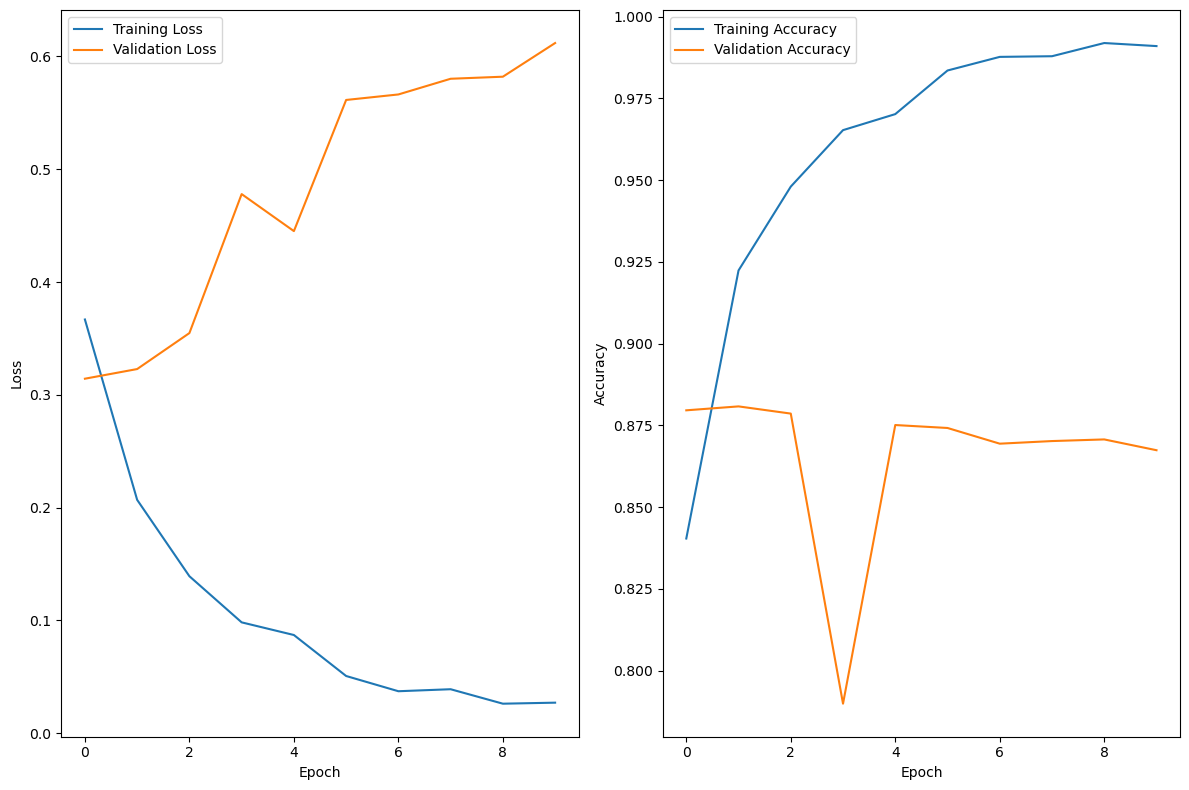

In [57]:
def history_plot(history):
    
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    ax1.plot(train_loss, label='Training Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(train_accuracy, label='Training Accuracy')
    ax2.plot(val_accuracy, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

history_plot(history)

313/313 [==============================] - 32s 103ms/step
---------- Evaluation Metrics for lstm_index_cleaned_stemmed_review ----------

F1 score: 0.865
Precision score: 0.882
Recall score: 0.848
Average precision-recall score: 0.824



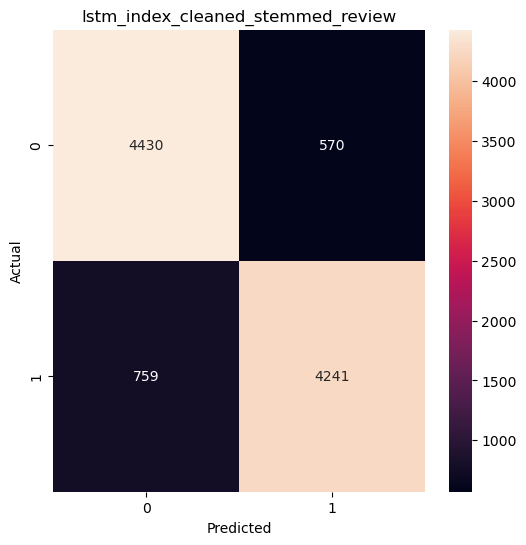

In [60]:
from sklearn import metrics
def print_eval(y_test, result, title, ax=None):
    
    if ax == None:
        fig, ax = plt.subplots(1,1,figsize=(6,6))
    
    confuse = metrics.confusion_matrix(y_test, result)
    sns.heatmap(confuse, annot = True, fmt='d', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score = metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)
    
    print(f"---------- Evaluation Metrics for {title} ----------\n")
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}\n'.format(average_precision))

def predict_eval(model, X_test, y_test, title):
    result = model.predict(X_test)
    result = result>0.5

    fig, ax = plt.subplots(1,1,figsize=(6,6))
    print_eval(y_test, result, title, ax)
    plt.show()

predict_eval(lstm_model_index, X_test_dict['index_cleaned_stemmed_review'], y_test, 'lstm_index_cleaned_stemmed_review')